# QY measurements in the sphere!

First, let's do a wavelength calibration:

In [1]:
%pylab
import FluorSpec.PTI_Data
import os
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
## NOTE THAT THIS IS NOT THE SAME FITTER AS IS USED IN THE RELATIVE QY MEASUREMENT ANALYSIS
import numpy as np
from scipy.optimize import leastsq

class fitter():
    '''
    This class will handle fitting for this analysis.
    '''
    def __init__(self):
        #initialise with (xlow, xhigh) = (150, 250)
        self.xlow = 150
        self.xhigh = 250
        return
    
    def set_template_object(self, template):
        self.template = template
        return
    
    def get_template_object(self):
        return self.template
    
    def interp_template(self, newxvals, shift=0):
        #print("Fixing Template WL values!")
        #print("newxvalues = {0}".format(newxvals))
        #print("template x values = {0}".format(self.template.WL))
        self.template.FileSpecCorrected = np.interp(newxvals, np.array(self.template.WL) + shift, 
                                                   self.template.FileSpecCorrected)
        self.template.WL = newxvals
        return
    
    def set_fit_range(self, xlow, xhigh):
        self.xlow = xlow
        self.xhigh = xhigh
        return
    
    def template_scale(self, factor):
        #This is just setting the fit range, so searchsorted should be OK.
        idx_xlow = np.searchsorted(self.template.WL, self.xlow)
        idx_xhigh = np.searchsorted(self.template.WL, self.xhigh)
        return np.array(self.template.FileSpecCorrected[slice(idx_xlow, idx_xhigh)])*factor

    def DoubleGauss(self, x, p):
        #A1, mu1, sigma1, A2, mu2, sigma2 = p
        return p[0]*np.exp(-(x-p[2])**2/(2.*p[3]**2)) + p[1]*np.exp(-(x-p[4])**2/(2.*p[5]**2))

    def fit_function(self, p0, data, function, sigma=None):
                     #cf_func=template_scale, **kwargs):
        
        #This code was from when I was passing an object: it's better to pass just the list of y-values instead!
        datax = data.WL
        #Again, searchsorted is fine here as it's just setting the fit range.
        idx_xlow = np.searchsorted(datax, self.xlow)
        idx_xhigh = np.searchsorted(datax, self.xhigh)
        tidx_xlow = np.searchsorted(self.template.WL, self.xlow)
        tidx_xhigh = np.searchsorted(self.template.WL, self.xhigh)
        datay = data.sample[slice(idx_xlow, idx_xhigh)]
        #np.interp(self.template.WL[slice(tidx_xlow, tidx_xhigh)], 
        #         data.WL[slice(idx_xlow, idx_xhigh)], data.FileSpecCorrected[slice(idx_xlow, idx_xhigh)])
        
        errfunc = lambda p, y: function(p) - y

        ##################################################
        ## 1. COMPUTE THE FIT AND FIT ERRORS USING leastsq
        ##################################################

        # If using optimize.leastsq, the covariance returned is the 
        # reduced covariance or fractional covariance, as explained
        # here :
        # http://stackoverflow.com/questions/14854339/in-scipy-how-and-why-does-curve-fit-calculate-the-covariance-of-the-parameter-es
        # One can multiply it by the reduced chi squared, s_sq, as 
        # it is done in the more recenly implemented scipy.curve_fit
        # The errors in the parameters are then the square root of the 
        # diagonal elements.   

        pfit, pcov, infodict, errmsg, success = \
            leastsq(errfunc, p0, args=(datay), \
                    full_output=1)

        if (len(datay) > len(p0)) and pcov is not None:
            s_sq = (errfunc(pfit, datay)**2).sum()/(len(datay)-len(p0))
            pcov = pcov * s_sq
        else:
            pcov = np.inf

        error = [] 
        for i in range(len(pfit)):
            try:
                error.append( np.absolute(pcov[i][i])**0.5)
            except:
                error.append( 0.00 )
        pfit_leastsq = pfit
        perr_leastsq = np.array(error) 
        return pfit_leastsq, perr_leastsq#pfit_curvefit, perr_curvefit#_bootstrap

In [5]:
from scipy.optimize import curve_fit

def Gauss_cf(x, p):
    return p[0]*np.exp(-(x-p[1])**2/(2.*p[2]**2))

def DoubleGauss_cf(x, p):
    return p[0]*np.exp(-(x-p[1])**2/(2.*p[2]**2)) + p[3]*np.exp(-(x-p[4])**2/(2.*p[5]**2))

def TripleGauss_cf(x, p):
    return p[0]*np.exp(-(x-p[1])**2/(2.*p[2]**2)) + p[3]*np.exp(-(x-p[4])**2/(2.*p[5]**2)) + \
           p[6]*np.exp(-(x-p[7])**2/(2.*p[8]**2))

def FiveGauss_cf(x,p):
    return p[0]*np.exp(-(x-p[1])**2/(2.*p[2]**2)) + p[3]*np.exp(-(x-p[4])**2/(2.*p[5]**2)) + \
           p[6]*np.exp(-(x-p[7])**2/(2.*p[8]**2)) + p[9]*np.exp(-(x-p[10])**2/(2.*p[11]**2)) + \
           p[12]*np.exp(-(x-p[13])**2/(2.*p[14]**2))

def subtractBL(x, y, avglen):
    '''
    Linearly interpolate under a peak.
    '''
    yfit = y[0:avglen] + y[-avglen:]
    xfit = x[0:avglen] + x[-avglen:]
    m,b = np.polyfit(xfit, yfit, 1)
    BL = np.multiply(m,x) + b
    return BL, y - BL

def fit_function(p0, x, y, function, sigma=None):    
        errfunc = lambda p, x, y: function(x, p) - y

        pfit, pcov, infodict, errmsg, success = \
            leastsq(errfunc, p0, args=(x,y), \
                    full_output=1)

        if (len(y) > len(p0)) and pcov is not None:
            s_sq = (errfunc(pfit, x, y)**2).sum()/(len(y)-len(p0))
            pcov = pcov * s_sq
        else:
            pcov = np.inf

        error = [] 
        for i in range(len(pfit)):
            try:
                error.append( np.absolute(pcov[i][i])**0.5)
            except:
                error.append( 0.00 )
        pfit_leastsq = pfit
        perr_leastsq = np.array(error) 
        return pfit_leastsq, perr_leastsq

def fitpeak(x, y, fitlowWL, fithighWL, model, paramguess, avglen=3, makefigs=False):
    '''
    Fit a peak in data within a certain fitregion (slice), using a fit model with initial paramguess.
    Returns the fit parameters and uncertainty.
    '''
    lowidx = x.index(fitlowWL)
    highidx = x.index(fithighWL)
    fitslice = slice(lowidx, highidx)
    datax = x[fitslice]
    datay = y[fitslice]
    datayerrors = np.sqrt(datay)
    BL, datay_corr = subtractBL(datax, datay, avglen)
    if makefigs:
        fig = plt.figure()
        plot(datax, datay, label='original')
        plot(datax, BL, label='baseline')
        plot(datax, datay_corr, label='BL corrected')
        plt.xlabel("Wavelength (nm)", fontsize=16)
        plt.ylabel("Fluorescence Intensity", fontsize=16)
        legend()

    print("Fitting peak: param guess = {0}, model = {1}".format(paramguess, model))
    pfit, pcov = fit_function(paramguess, datax, datay_corr, model, datayerrors)
    print("success! Parameters: {0}".format(pfit))
    if makefigs:
        xvals = np.linspace(min(datax), max(datax), 1000)
        yvals = model(xvals, pfit)
        plot(xvals, yvals, label='Fit')
        if len(pfit)==3:
            title("Fit values:\nmean = {0:.2f} nm, std = {1:.2f} nm".format(pfit[1], pfit[2]), fontsize=18)
        else:
            title("Fit values:\nmean = {0:.2f} nm, std = {1:.2f} nm\nmean = {2:.2f}, std = {3:.2f}"\
                  .format(pfit[1], pfit[2], pfit[4], pfit[5]), fontsize=18)
        legend()

    return pfit, pcov

Initializing PTI_Data at Wed Oct  5 09:38:45 2016
CWT wavelet approach...
Peaks found at: [401.0, 432.0, 486.0, 541.0, 567.0]
Fitting peak: param guess = [5000, 400, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  9.36002264e+03   4.00610427e+02   9.74194173e-01]
Fitting peak: param guess = [20000, 431, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  4.84687790e+04   4.31418370e+02   9.53978686e-01]
Fitting peak: param guess = [40000, 537, 2, 50000, 540, 2, 20000, 545, 2], model = <function TripleGauss_cf at 0x0000000007DEE268>
success! Parameters: [  7.25384257e+04   5.39432996e+02   2.17788987e+00   3.63579573e+04
   5.42041604e+02   9.50684552e-01   1.58717867e+04   5.46248522e+02
   2.69988790e+00]
First peak difference: -4.045872845224778 nm
Second peak difference: -4.414429693906527 nm
Third peak difference: -3.092303742117906 nm
Fourth peak difference: -4.031895596575964 nm
Mean Emission Monochromator offset = -4.164066

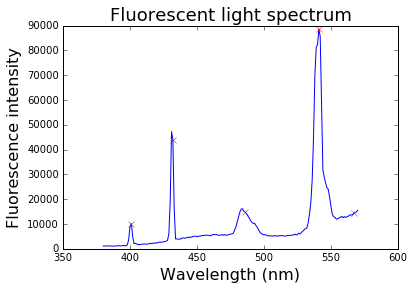

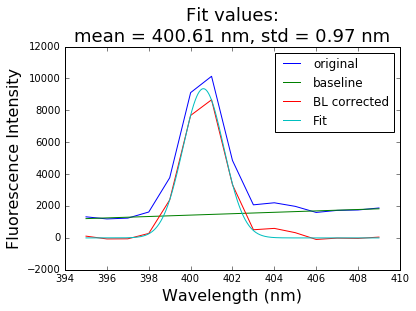

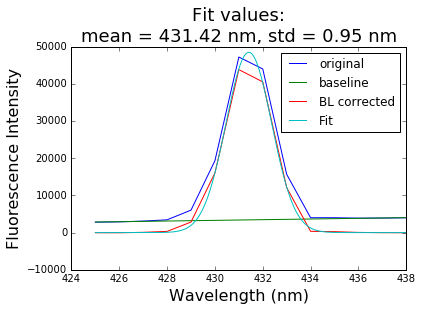

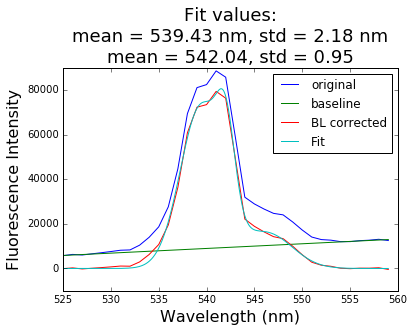

In [6]:
#%matplotlib qt4#Qt4Agg
from scipy.signal import find_peaks_cwt

mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\WLcalib\\RoomLights_NoCalShift_2.txt"
FluoLight = FluorSpec.PTI_Data.PTI_Data(mypath)
fig = figure()
plot(FluoLight.WL, FluoLight.FileSpecCorrected)
pk_ind = find_peaks_cwt(FluoLight.FileSpecCorrected, np.arange(7,8))
pk_WL =[FluoLight.WL[val] for val in pk_ind]
print("CWT wavelet approach...\nPeaks found at: {0}".format(pk_WL))
pk_sig = [FluoLight.FileSpecCorrected[val] for val in pk_ind]
plot(pk_WL, pk_sig, 'rx', linewidth=3)
#xlim(425,439)
xlabel("Wavelength (nm)", fontsize=16)
ylabel("Fluorescence intensity", fontsize=16)
title("Fluorescent light spectrum", fontsize=18)

startranges = [395, 425, 525]
endranges = [410, 439, 560]
paramguesses = [[5000, 400, 2], [20000, 431, 2], [40000, 537, 2, 50000, 540, 2, 20000, 545, 2]]
models = [Gauss_cf, Gauss_cf, TripleGauss_cf]
#pfit, pcov = fitpeak(FluoLight.WL, FluoLight.FileSpecCorrected, 395, 410, Gauss_cf, [20000, 402, 5], makefigs=True)
fitreturn = [fitpeak(FluoLight.WL, FluoLight.FileSpecCorrected, startranges[i], endranges[i], 
                        models[i], paramguesses[i], makefigs=True) for i in range(3)]

#Expected WL
Expected_WL = [404.6563, 435.8328, 542.5253, 546.0735]
print("First peak difference: {0} nm".format(fitreturn[0][0][1] - Expected_WL[0]))
print("Second peak difference: {0} nm".format(fitreturn[1][0][1] - Expected_WL[1]))
print("Third peak difference: {0} nm".format(fitreturn[2][0][1] - Expected_WL[2]))
print("Fourth peak difference: {0} nm".format(fitreturn[2][0][4] - Expected_WL[3]))
EmMonoOffset = sum([fitreturn[0][0][1] - Expected_WL[0], fitreturn[1][0][1] - Expected_WL[1],
                       #fitreturn[2][0][1] - Expected_WL[2], fitreturn[2][0][4] - Expected_WL[3]])/4
                    fitreturn[2][0][4] - Expected_WL[3]])/3
UEmMonoOffset = np.std([fitreturn[0][0][1] - Expected_WL[0], fitreturn[1][0][1] - Expected_WL[1],
                       #fitreturn[2][0][1] - Expected_WL[2], fitreturn[2][0][4] - Expected_WL[3]])
                        fitreturn[2][0][4] - Expected_WL[3]])
print("Mean Emission Monochromator offset = {0} +/- {1} nm".format(EmMonoOffset, UEmMonoOffset))

# Measurements with David on 2016-08-23

Initializing PTI_Data at Wed Oct  5 09:38:58 2016
CWT wavelet approach...
Peaks found at: [357.0, 405.0, 436.0, 490.0, 545.0, 588.0]
Fitting peak: param guess = [5000, 400, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  1.51152321e+04   4.04632495e+02   9.24507628e-01]
Fitting peak: param guess = [20000, 431, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  8.28122963e+04   4.35561653e+02   9.40407351e-01]
Fitting peak: param guess = [40000, 542, 2, 50000, 545, 2, 20000, 553, 2], model = <function TripleGauss_cf at 0x0000000007DEE268>
success! Parameters: [  1.09500616e+05   5.43414100e+02   1.72917971e+00   7.90360941e+04
   5.46144064e+02   8.85805857e-01   4.01711723e+04   5.46877809e+02
   4.96308688e+00]
First peak difference: -0.02380469809565966 nm
Second peak difference: -0.2711468658408762 nm
Third peak difference: 0.8887999026594571 nm
Fourth peak difference: 0.07056375709362328 nm
Mean Emission Monochromator offset 

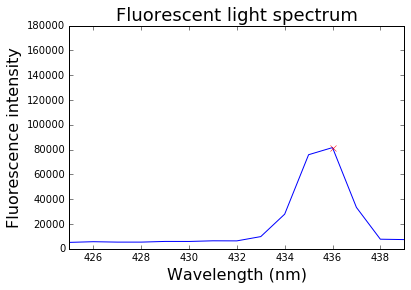

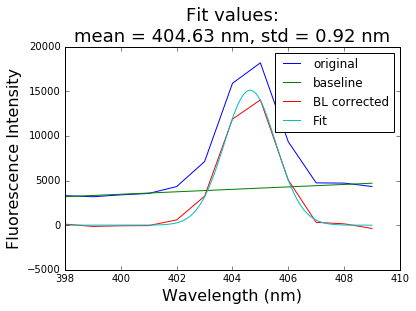

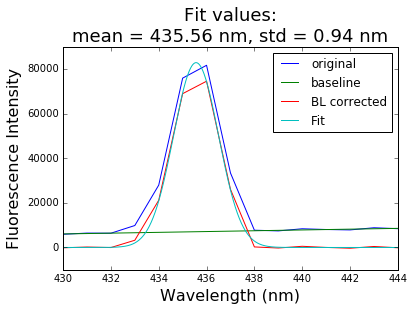

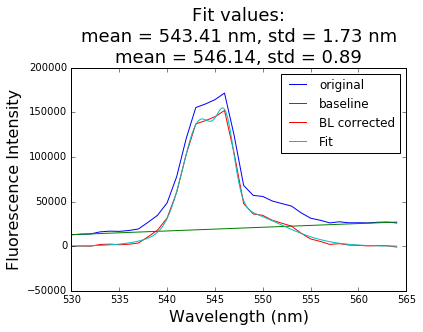

In [7]:
#%matplotlib qt4#Qt4Agg
from scipy.signal import find_peaks_cwt

mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\WLcalib\\RoomLights_Calibrated_160823.txt"
FluoLight = FluorSpec.PTI_Data.PTI_Data(mypath)
fig = figure()
plot(FluoLight.WL, FluoLight.FileSpecCorrected)
pk_ind = find_peaks_cwt(FluoLight.FileSpecCorrected, np.arange(7,8))
pk_WL =[FluoLight.WL[val] for val in pk_ind]
print("CWT wavelet approach...\nPeaks found at: {0}".format(pk_WL))
pk_sig = [FluoLight.FileSpecCorrected[val] for val in pk_ind]
plot(pk_WL, pk_sig, 'rx', linewidth=3)
xlim(425,439)
xlabel("Wavelength (nm)", fontsize=16)
ylabel("Fluorescence intensity", fontsize=16)
title("Fluorescent light spectrum", fontsize=18)

startranges = [398, 430, 530]
endranges = [410, 445, 565]
paramguesses = [[5000, 400, 2], [20000, 431, 2], [40000, 542, 2, 50000, 545, 2, 20000, 553, 2]]
models = [Gauss_cf, Gauss_cf, TripleGauss_cf]
#pfit, pcov = fitpeak(FluoLight.WL, FluoLight.FileSpecCorrected, 395, 410, Gauss_cf, [20000, 402, 5], makefigs=True)
fitreturn = [fitpeak(FluoLight.WL, FluoLight.FileSpecCorrected, startranges[i], endranges[i], 
                        models[i], paramguesses[i], makefigs=True) for i in range(3)]

#Expected WL
Expected_WL = [404.6563, 435.8328, 542.5253, 546.0735]
print("First peak difference: {0} nm".format(fitreturn[0][0][1] - Expected_WL[0]))
print("Second peak difference: {0} nm".format(fitreturn[1][0][1] - Expected_WL[1]))
print("Third peak difference: {0} nm".format(fitreturn[2][0][1] - Expected_WL[2]))
print("Fourth peak difference: {0} nm".format(fitreturn[2][0][4] - Expected_WL[3]))
EmMonoOffset = sum([fitreturn[0][0][1] - Expected_WL[0], fitreturn[1][0][1] - Expected_WL[1],
                       #fitreturn[2][0][1] - Expected_WL[2], fitreturn[2][0][4] - Expected_WL[3]])/4
                    fitreturn[2][0][4] - Expected_WL[3]])/3
UEmMonoOffset = np.std([fitreturn[0][0][1] - Expected_WL[0], fitreturn[1][0][1] - Expected_WL[1],
                       #fitreturn[2][0][1] - Expected_WL[2], fitreturn[2][0][4] - Expected_WL[3]])
                        fitreturn[2][0][4] - Expected_WL[3]])
print("Mean Emission Monochromator offset = {0} +/- {1} nm".format(EmMonoOffset, UEmMonoOffset))

Initializing PTI_Data at Wed Oct  5 09:39:02 2016
Fitting peak: param guess = [10000, 351, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  2.57127968e+05   3.50651340e+02   1.27317179e+00]
Initializing PTI_Data at Wed Oct  5 09:39:02 2016
Fitting peak: param guess = [10000, 401, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  2.81056619e+05   4.00592633e+02   1.28188476e+00]


C:\Users\Samsung\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in sqrt


Initializing PTI_Data at Wed Oct  5 09:39:02 2016
Fitting peak: param guess = [10000, 451, 2], model = <function Gauss_cf at 0x0000000007723D90>
success! Parameters: [  2.54316561e+05   4.50283124e+02   1.26876718e+00]
Relative offset between excitation and emission monochromator: -0.5090319743842429 +/- 0.00803249348025638 nm
Absolute excitation monochromator offset = -0.5838279099985471 +/- 0.1443107725514594 nm


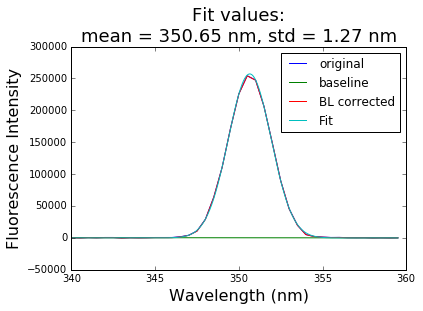

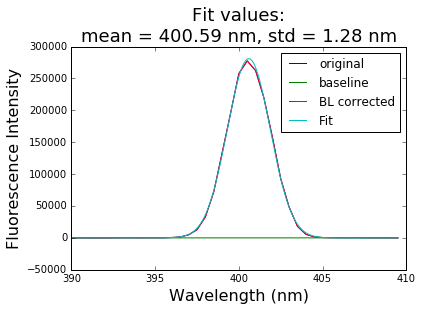

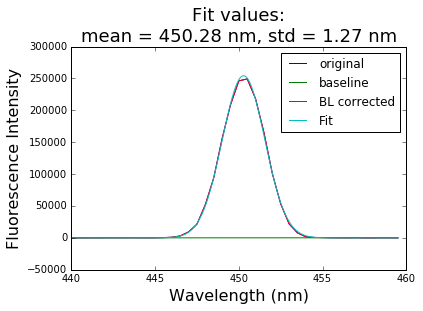

In [8]:
mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\WLcalib\\ExCal_350nm_20160823.txt"
Ex350 = FluorSpec.PTI_Data.PTI_Data(mypath)
fit350 = fitpeak(Ex350.WL, Ex350.FileSpecCorrected, 340, 360, Gauss_cf, [10000, 351, 2], makefigs=True)

mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\WLcalib\\ExCal_400nm_20160823.txt"
Ex400 = FluorSpec.PTI_Data.PTI_Data(mypath)
fit400 = fitpeak(Ex400.WL, Ex400.FileSpecCorrected, 390, 410, Gauss_cf, [10000, 401, 2], makefigs=True)

mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\WLcalib\\ExCal_450nm_20160823.txt"
Ex450 = FluorSpec.PTI_Data.PTI_Data(mypath)
fit450 = fitpeak(Ex450.WL, Ex450.FileSpecCorrected, 440, 460, Gauss_cf, [10000, 451, 2], makefigs=True)

EmRelEx = np.mean([450 - fit450[0][1], 400 - fit400[0][1], 350 - fit350[0][1]])
UEmRelEx = np.sqrt(fit450[1][1]**2 + fit400[1][1]**2 + fit350[1][1]**2)
print("Relative offset between excitation and emission monochromator: {0} +/- {1} nm".format(EmRelEx, UEmRelEx))
ExMonoOffset = EmMonoOffset + EmRelEx
UExMonoOffset = np.sqrt(UEmRelEx**2 + UEmMonoOffset**2)
print("Absolute excitation monochromator offset = {0} +/- {1} nm".format(ExMonoOffset, UExMonoOffset))

# Now to check the emission correction!

- Sync Scan was taken with nothing in the sphere. I took measurements with/without using the excitation correction, but I think the correct way is to use the file excitation correction.

Initializing PTI_Data at Wed Oct  5 09:39:07 2016
Initializing PTI_Data at Wed Oct  5 09:39:07 2016
Initializing PTI_Data at Wed Oct  5 09:39:07 2016


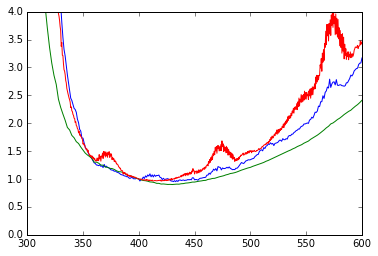

In [9]:
#mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\EmissionCorrection\\SyncScan_DefaultExcorr_NoExcorr.txt"
mypath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\EmissionCorrection\\SyncScan_ExcorrFile_NoExcorr.txt"
mypath2 = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\EmissionCorrection\\SyncScan_ExcorrFile_NoEmcorr_160823.txt"
SyncScan = FluorSpec.PTI_Data.PTI_Data(mypath)
WLcorrection = (1/(np.array(SyncScan.FileSpecCorrected)))
fig = figure()
plot(SyncScan.WL, WLcorrection/(WLcorrection[SyncScan.WL.index(400)]))
ylim(0,4)
xlim(300,600)

mypath = "C:\\Users\\Samsung\\Documents\\GitHub\\FluorSpec\\correction_data\\emcorr-sphere-quanta.txt"
corrfile = FluorSpec.PTI_Data.PTI_Data(mypath)
WLcorrfile = (np.array(corrfile.Trace))
plot(corrfile.WL, WLcorrfile/(WLcorrfile[corrfile.WL.index(400)]))

#Override the WLcorrection with the more recent data
SyncScan = FluorSpec.PTI_Data.PTI_Data(mypath2)
WLcorrection = (1/(np.array(SyncScan.FileSpecCorrected)))
plot(SyncScan.WL, WLcorrection/(WLcorrection[SyncScan.WL.index(400)]))


In [10]:
import matplotlib.pyplot as plt
import FluorSpec.PTI_Data
from scipy.integrate import trapz

def CalcQY(solventpath, samplepath, templatepath, correctionpath, AbsWLmin, AbsWLmax, EmWLmin, EmWLmax, FitWLmin, FitWLmax, 
          FileWLCorr=False, makeplots=True, avglen=10, BLoffsetrange=slice(-10,-1), templateshift=0):
    '''
    Calculate the QY using measurement files.
    
    Provide paths to 'session' type files for solvent, sample, a template spectrum (for reabsorption correction), and a
    wavelength correction. Note that the wavelength correction file can either use a sync scan measurement through an empty
    sphere (default) or be one of the files provided by PTI (if FileWLCorr is True).
    
    Integration ranges are set by AbsWLmin/max and EmWLmin/max. The template is fitted to the measurement using FitWLmin/max.
    
    The remaining arguments cover plot creation, and the baseline averaging length.
    '''
    
    solventobj = FluorSpec.PTI_Data.PTI_Data(solventpath)
    sampleobj = FluorSpec.PTI_Data.PTI_Data(samplepath)
    template = FluorSpec.PTI_Data.PTI_Data(templatepath)
    solvent_BL, solvent_BLsub = subtractBL(solventobj.WL, list(solventobj.FileSpecCorrected), avglen)
                                   #list(solventobj.FileSpecCorrected - \
                                   #     np.mean(solventobj.FileSpecCorrected[BLoffsetrange])), avglen)
    sample_BL, sample_BLsub = subtractBL(sampleobj.WL, list(sampleobj.FileSpecCorrected), avglen)
                                   #list(sampleobj.FileSpecCorrected - \
                                   #     np.mean(sampleobj.FileSpecCorrected[BLoffsetrange])), avglen)
    correctionobj = FluorSpec.PTI_Data.PTI_Data(correctionpath)
    if FileWLCorr:
        WLcorrection = (np.array(correctionobj.Trace))
    else:
        WLcorrection = (1/(np.array(correctionobj.FileSpecCorrected)))

    WLcorr = np.interp(solventobj.WL, np.array(correctionobj.WL), WLcorrection)

    if makeplots:
        fig = plt.figure()
        yvals = solventobj.FileSpecCorrected-np.mean(solventobj.FileSpecCorrected[BLoffsetrange])
        plt.plot(solventobj.WL, yvals)
        plt.ylim(-max(yvals)/100,max(yvals)/20)
        plt.plot(sampleobj.WL, sampleobj.FileSpecCorrected-np.mean(sampleobj.FileSpecCorrected[BLoffsetrange]))
        plt.plot(solventobj.WL, solvent_BL)
        plt.plot(sampleobj.WL, sample_BL)

    solvent1 = (solventobj.FileSpecCorrected - solvent_BL)
    solvent = (solvent1 - np.mean(solvent1[BLoffsetrange]))*WLcorr
    Usolvent = solventobj.UFileSpecCorrected*WLcorr
    sample1 = (sampleobj.FileSpecCorrected - sample_BL)
    sample = (sample1 - np.mean(sample1[BLoffsetrange]))*WLcorr
    Usample = sampleobj.UFileSpecCorrected*WLcorr
    sampleobj.sample = sample

    if makeplots:
        plt.fig = figure()
        plt.plot(sampleobj.WL, sample)
        plt.plot(solventobj.WL, solvent)
        plt.ylim(-max(solvent)/200,max(solvent)/50)

    xlow_abs = solventobj.WL.index(AbsWLmin)
    xhigh_abs = solventobj.WL.index(AbsWLmax)
    Npeak = sum(solventobj.FileSpecCorrected[xlow_abs:xhigh_abs])
    print("# counts in peak = {0}".format(Npeak))
    Nabs = sum(solvent[xlow_abs:xhigh_abs]) - sum(sample[xlow_abs:xhigh_abs])
    #UNabs = np.sqrt(sum(solvent[xlow_abs:xhigh_abs])**2 + sum(sample[xlow_abs:xhigh_abs])**2)
    Ncounts = sum(solventobj.FileSpecCorrected[xlow_abs:xhigh_abs]) - sum(sampleobj.FileSpecCorrected[xlow_abs:xhigh_abs])
    print("# absorbed (uncorrected) = {0}".format(Ncounts))
    #UNabs = Nabs*(np.sqrt(Ncounts)/Ncounts)**2
    UNabs = np.sqrt(sum(Usolvent[xlow_abs:xhigh_abs]**2) + sum(Usample[xlow_abs:xhigh_abs]**2))

    xlow_emit = solventobj.WL.index(EmWLmin)
    xhigh_emit = solventobj.WL.index(EmWLmax)
    Nemit = sum(sample[xlow_emit:xhigh_emit]) - sum(solvent[xlow_emit:xhigh_emit])
    Nemit2 = sum(sample[xlow_emit:xhigh_emit])
    Ncounts = sum(sampleobj.FileSpecCorrected[xlow_emit:xhigh_emit]) - sum(solventobj.FileSpecCorrected[xlow_emit:xhigh_emit])
    #UNemit = Nemit*(np.sqrt(Ncounts)/Ncounts)**2
    UNemit = np.sqrt(sum(Usample[xlow_emit:xhigh_emit]**2) + sum(Usolvent[xlow_emit:xhigh_emit]**2))

    QY = Nemit/Nabs
    QY2 = Nemit2/Nabs
    UQY = QY*(np.sqrt((UNemit/Nemit)**2 + (UNabs/Nabs)**2))
    print("Nemit = {0}".format(Nemit))
    print("Nabs = {0}".format(Nabs))
    print("QY = {0} +/- {1}".format(QY, UQY))
    #print("Linear extrap QY = {0}".format(QY2))

    ##### REABSORPTION CORRECTION #####
    ftr = fitter()

    ftr.set_template_object(template)
    ftr.interp_template(solventobj.WL, templateshift)
    ftr.set_fit_range(FitWLmin, FitWLmax)
    #idx_xlow = np.searchsorted(sampleobj.WL, FitWLmin)
    #idx_xhigh = np.searchsorted(sampleobj.WL, FitWLmax)
    #datay = sample[slice(idx_xlow, idx_xhigh)]
    relhgt = max(sample)/max(template.FileSpecCorrected)
    pfit, perr = ftr.fit_function([relhgt], sampleobj, ftr.template_scale)
    print("pfit = {0} +/- {1}".format(pfit, perr))
    ReabsSpec = np.array(ftr.get_template_object().FileSpecCorrected)*pfit[0]

    if makeplots:
        fig = plt.figure()
        plt.plot(sampleobj.WL, np.array(sampleobj.sample), label="Sphere Measurement")
        plt.plot(ftr.get_template_object().WL, ReabsSpec, label="Box Measurement")
        plt.legend(fontsize=8)
        plt.ylim(-max(sampleobj.sample)/200,max(sampleobj.sample)/20)

    BL_reabs = np.interp(template.WL, sampleobj.WL, sample_BL)
    WLcorr_reabs = np.interp(template.WL, sampleobj.WL, WLcorr)

    xlow_emit_reabs = ftr.get_template_object().WL.index(EmWLmin)
    xhigh_emit_reabs = ftr.get_template_object().WL.index(EmWLmax)
    dx_template = ftr.get_template_object().WL[1] - ftr.get_template_object().WL[0]
    dx_solvent = solventobj.WL[1] - solventobj.WL[0]
    Fsample_reabs = trapz(ReabsSpec[xlow_emit_reabs:xhigh_emit_reabs], dx=dx_template)
    Fsolvent_reabs = trapz(solvent[xlow_emit:xhigh_emit], dx=dx_solvent)
    Nemit_reabs = Fsample_reabs - Fsolvent_reabs            

    Asample_reabs = trapz(sample[xlow_abs:xhigh_abs], dx=dx_solvent)
    Asolvent_reabs = trapz(solvent[xlow_abs:xhigh_abs], dx=dx_solvent)
    Nabs_reabs = Asolvent_reabs - Asample_reabs
    if "360" not in solventpath:
        FluorUnderAbsPeak = trapz(ReabsSpec[xlow_abs:xhigh_abs], dx=dx_template)
        fractionalChange = (Nabs_reabs-FluorUnderAbsPeak)/Nabs_reabs
        print("Correcting for fluorescence; fractional change = {0}".format(fractionalChange))
        Nabs_reabs -= FluorUnderAbsPeak

    #print("Nemit = {0}".format(Nemit_reabs))
    #print("Nabs = {0}".format(Nabs_reabs))

    QY_reabs = Nemit_reabs/Nabs_reabs
    UQY_reabs = QY_reabs*UQY/QY
    print("QY = {0} +/- {1}".format(QY_reabs, UQY_reabs))
    
    return QY_reabs, UQY_reabs


Initializing PTI_Data at Wed Oct  5 09:39:15 2016
Initializing PTI_Data at Wed Oct  5 09:39:15 2016
Initializing PTI_Data at Wed Oct  5 09:39:15 2016
Initializing PTI_Data at Wed Oct  5 09:39:15 2016
# counts in peak = 980200.570568
# absorbed (uncorrected) = 407621.0428839999
Nemit = 2.0738394066232084
Nabs = 2.6780360242590353
QY = 0.7743881664911519 +/- 0.002672160251392573
pfit = [  5.85002789e-09] +/- [  1.20001409e-10]
Correcting for fluorescence; fractional change = 0.9969760712898484
QY = 0.9716834025659233 +/- 0.003352961573573084


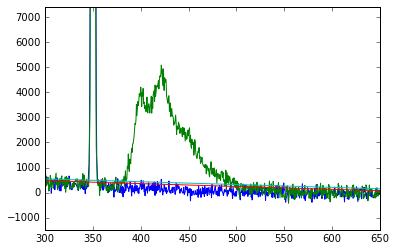

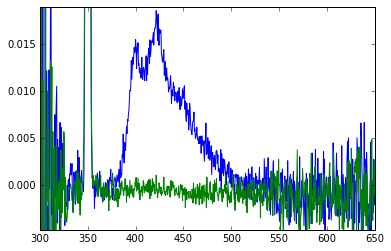

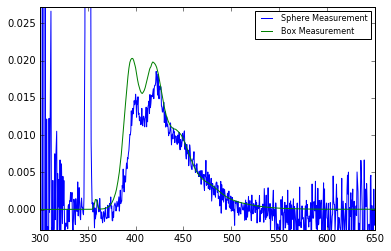

In [11]:
solventpath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\bisMSB_LAB\\EmissionScan_LAB_ex350_2sec_160823.txt"
#samplepath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\bisMSB_LAB\\EmissionScan_bisMSBinLAB_4.47mgL_ex350_2sec.txt"
samplepath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\bisMSB_LAB\\EmissionScan_bisMSBinLAB_4.47mgL_ex350_2sec_160824.txt"
FileWLCorr = False
makeplots = True
avglen = 10
BLoffsetrange = slice(-10, -1)

AbsWLmin = 340
AbsWLmax = 360
EmWLmin = 380
EmWLmax = 500

boxpath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Emission\\bisMSBlab\\"
#boxbisMSBinLABfiles = [f for f in os.listdir(boxpath) if os.path.isfile(os.path.join(boxpath, f))]
#boxbisMSBinLAB = [FluorSpec.PTI_Data.PTI_Data(boxpath + f) for f in boxbisMSBinLABfiles]
#fig = plt.figure()
#[plot(f.WL, np.array(f.FileSpecCorrected), 
#      label=f.FilePath.split('\\')[-1]) 
# for f in boxbisMSBinLAB]
#legend(fontsize=8)
#xlabel('Wavelength (nm)', fontsize=18)
#ylabel('Fluoresence Intensity', fontsize=18)
#title('bisMSB in LAB, in the box', fontsize=16)
#tight_layout()
#template = boxbisMSBinLAB[5]
FitWLmin = 450
FitWLmax = 500
templatepath = boxpath + 'bisMSB_LAB_0.894mgL_ex360.txt'

syncscanpath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\EmissionCorrection\\SyncScan_ExcorrFile_NoEmcorr_160823.txt"


QY_reabs, UQY_reabs = CalcQY(solventpath, samplepath, templatepath, syncscanpath, AbsWLmin, AbsWLmax, EmWLmin, EmWLmax,
                            FitWLmin, FitWLmax)

# Now to try doing them all at once...
## Note that the the cell two below needs to be run *before* the cell immediately below.

In [17]:
%matplotlib qt
print(metaresults)
fig = figure()
[plot([350 + i*10 for i in range(4)], [result[0] for result in metaresults[i]], 
      'x', markeredgewidth=4, markersize=10, label='{0} -- 500 nm'.format(420+i*10)) for i in range(7)]
ylim(0, 1)
xlim(340,390)
xlabel("Exciting Wavelength")
ylabel("Quantum Yield")
legend(loc="lower left", title="Integration Range")

#plt.fig = figure()
#plt.plot(sampleobj.WL, sample)
#plt.plot(solventobj.WL, solvent)
#plt.ylim(-max(solvent)/200,max(solvent)/50)
#plt.xlim(340,360)


[[(0.86773797135371833, 0.002973656027989408), (0.89936112732493678, 0.0027147638260588292), (0.74507824127871725, 0.0023290727157870687), (0.56777792144276873, 0.0015691088021798584)], [(0.88014522613747748, 0.0030161745176677697), (0.90368200056668346, 0.0027278065849876804), (0.77464656300894619, 0.002421501628051772), (0.58246720817732367, 0.0016097040564904952)], [(0.89334726285902666, 0.003061416649941326), (0.91343577864373282, 0.0027572488224676785), (0.79739680977880845, 0.0024926176211026115), (0.58955087424380659, 0.001629280447816838)], [(0.91645392700039985, 0.0031406010044112906), (0.90261953623278213, 0.0027245994864679435), (0.81643580011367767, 0.0025521324350756716), (0.60724902878835019, 0.0016781909972225216)], [(0.94284439297904021, 0.0032310386374635892), (0.95106577557389094, 0.0028708367365290217), (0.83142499604874731, 0.0025989878193156441), (0.62838382017518357, 0.0017365990225170699)], [(0.89970470592988161, 0.0030832030065770216), (0.93844016382336282, 0.00

Initializing PTI_Data at Wed Oct  5 09:39:28 2016
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
# counts in peak = 971992.58263
# absorbed (uncorrected) = 409366.37068199995
Nemit = 2.0738394066232084
Nabs = 2.683658912006829
QY = 0.772765643705593 +/- 0.002648194835871181
pfit = [  5.20577712e-09] +/- [  4.59131505e-11]
Correcting for fluorescence; fractional change = 0.9998834938581326
QY = 0.8677379713537183 +/- 0.002973656027989408
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
Initializing PTI_Data at Wed Oct  5 09:39:28 2016
# counts in peak = 1195377.9736920001
# absorbed (uncorrected) = 518423.9472350002
Nemit = 2.243261982276079
Nabs = 2.8128433392469097
QY = 0.7975069037711406 +/- 0.002407312065877012
pfit = [  5.68640388e-09] +/- [  4.64421250e-11]
QY = 0.8993611273249368

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Correcting for fluorescence; fractional change = 0.9987932218880317
QY = 0.7746465630089462 +/- 0.002421501628051772
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
# counts in peak = 1705822.636113
# absorbed (uncorrected) = 717949.6672490002
Nemit = 1.8405258457773113
Nabs = 3.6506568120684113
QY = 0.5041629330077989 +/- 0.0013933026735261879
pfit = [  4.94448351e-09] +/- [  5.87962580e-11]
Correcting for fluorescence; fractional change = 0.9903552215835635
QY = 0.5824672081773237 +/- 0.0016097040564904952
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
Initializing PTI_Data at Wed Oct  5 09:39:30 2016
# counts in peak = 971992.58263
# absorbed (uncorrected) = 409366.37068199995
Nemit = 2.0738394066232084
Nabs = 2.683658912006829
QY =

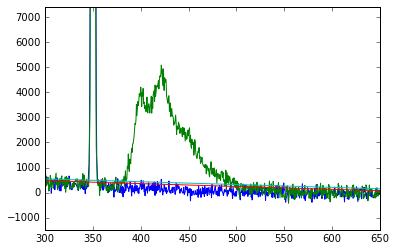

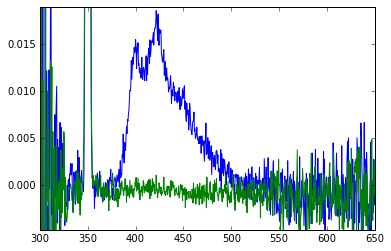

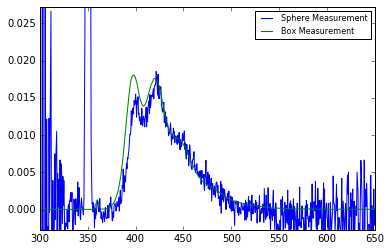

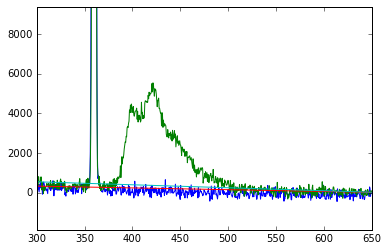

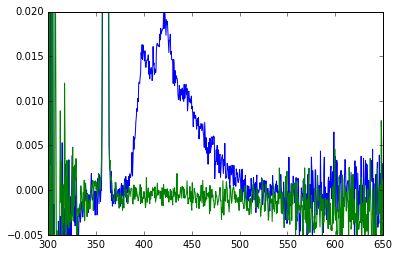

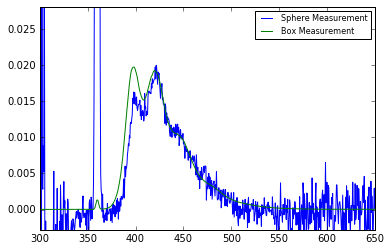

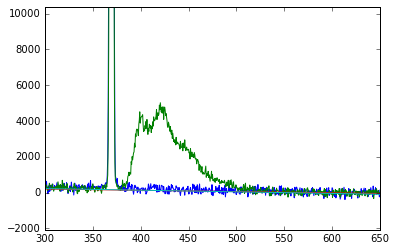

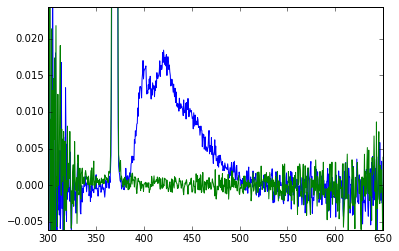

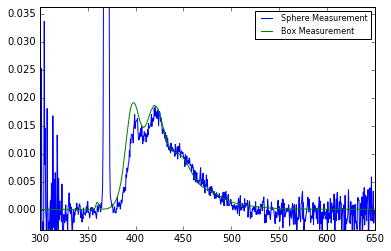

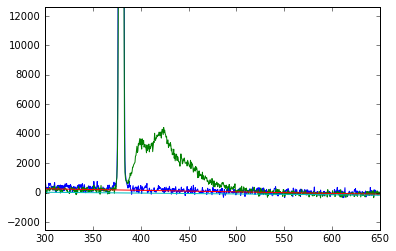

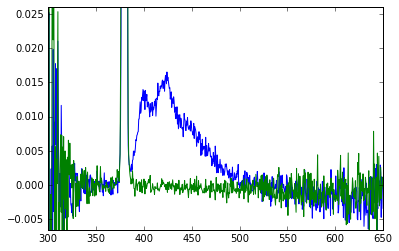

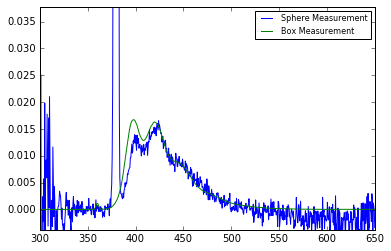

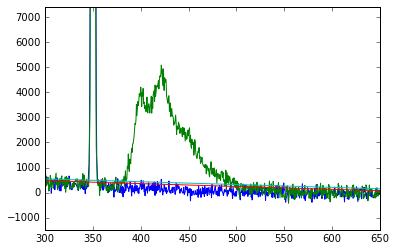

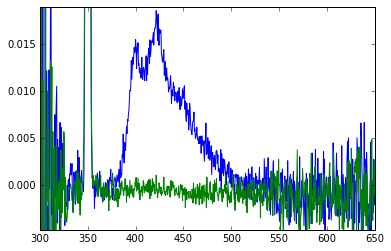

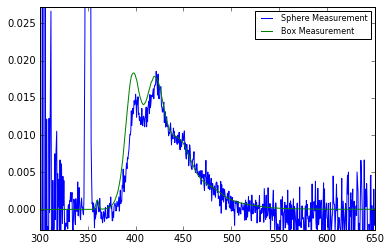

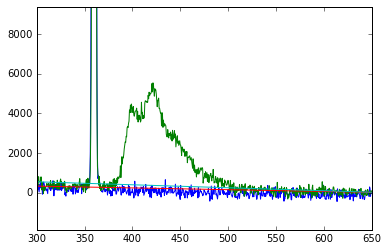

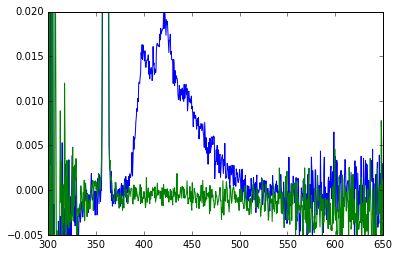

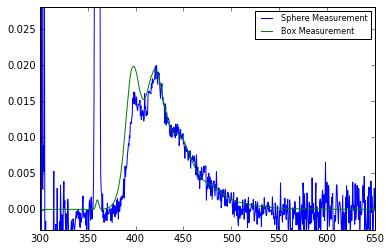

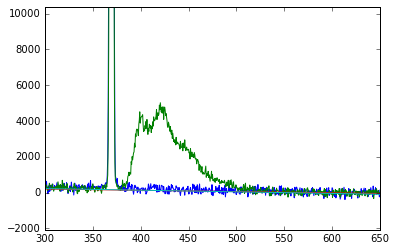

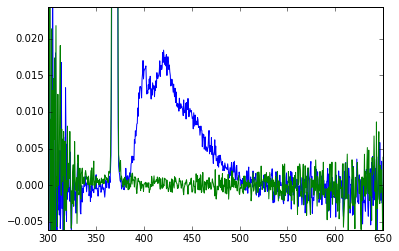

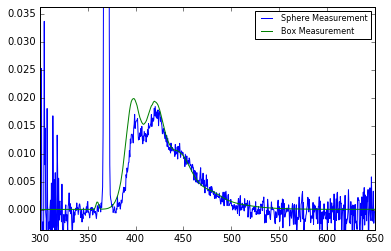

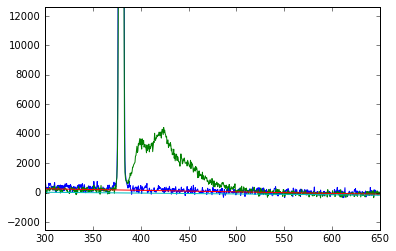

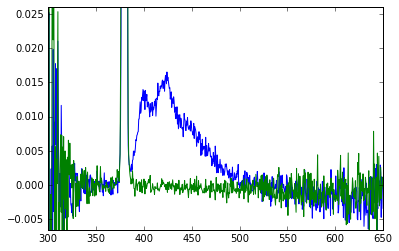

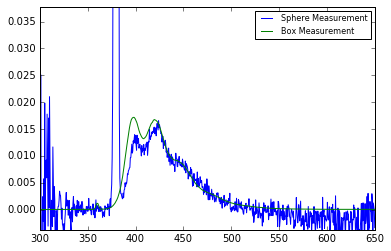

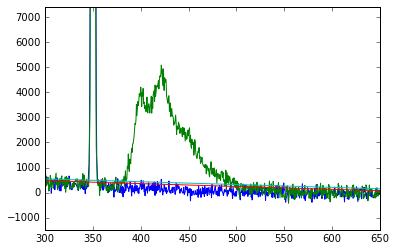

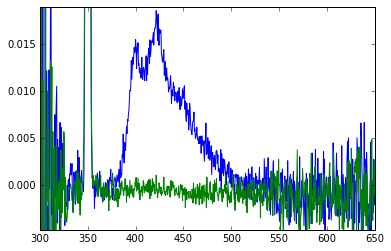

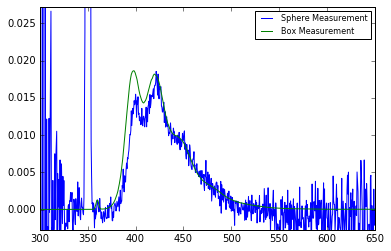

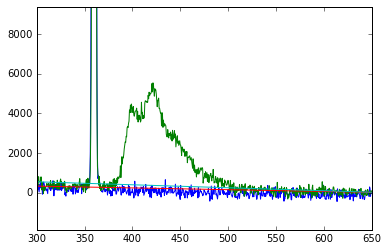

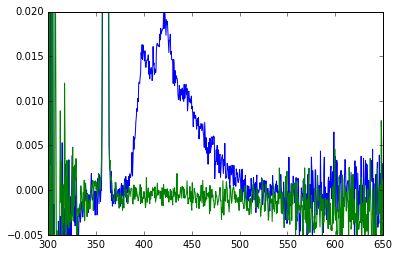

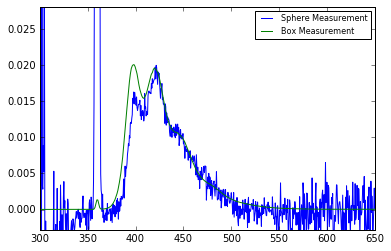

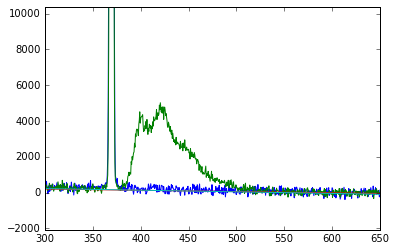

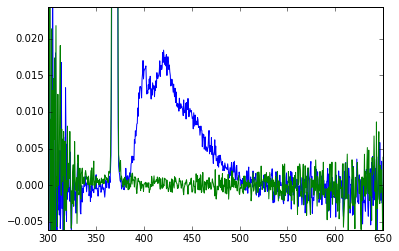

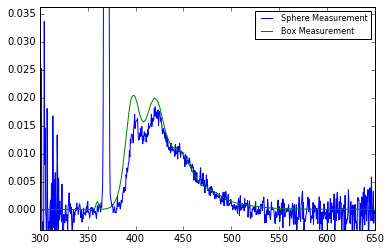

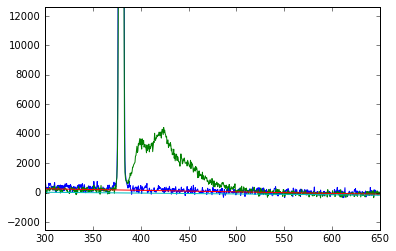

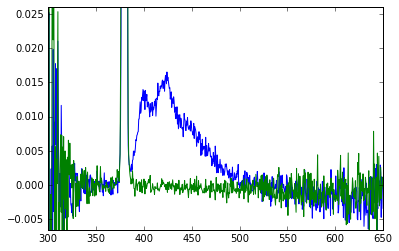

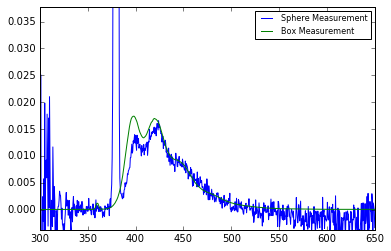

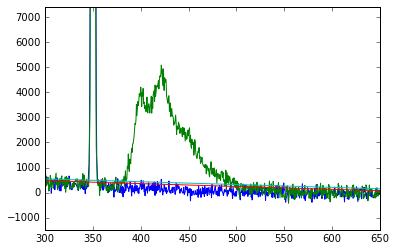

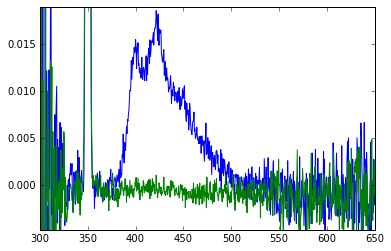

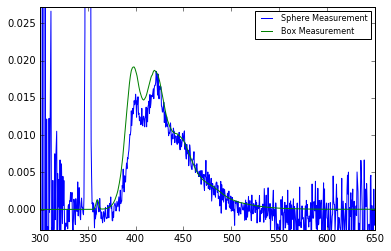

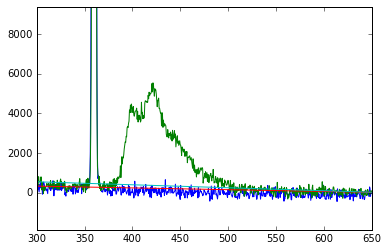

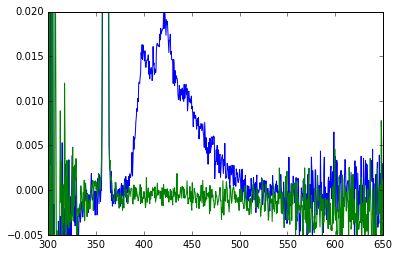

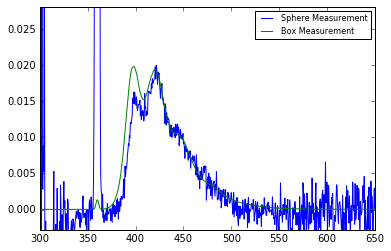

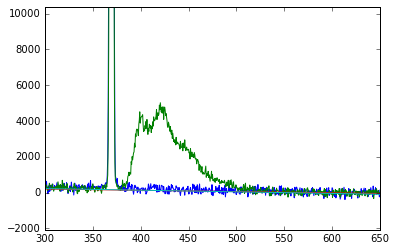

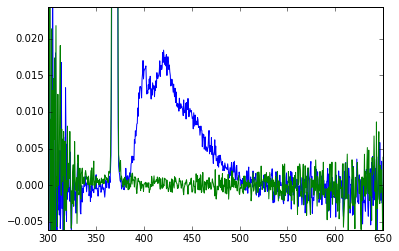

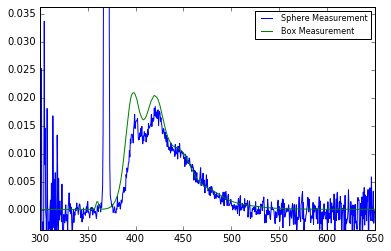

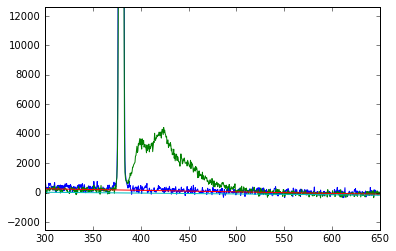

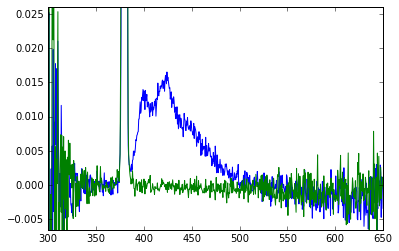

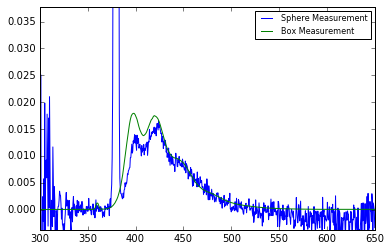

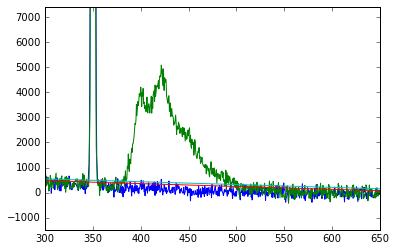

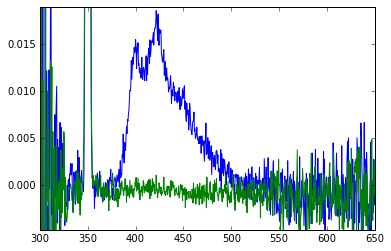

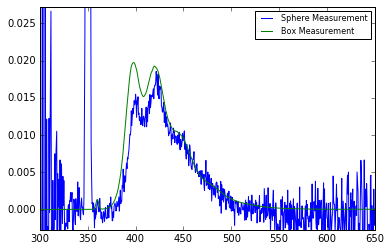

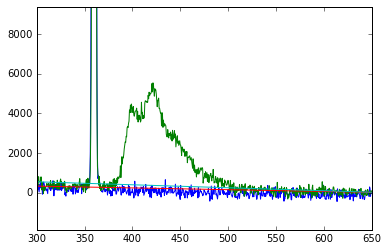

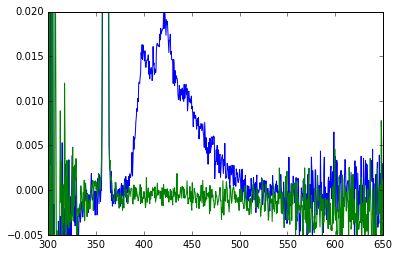

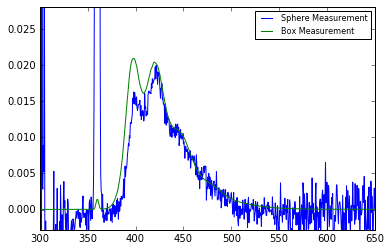

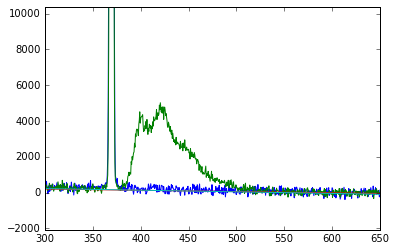

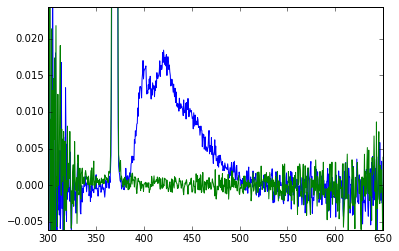

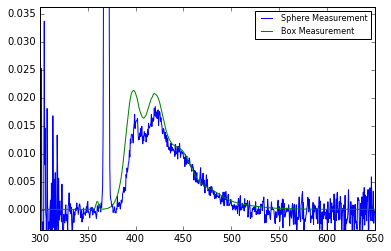

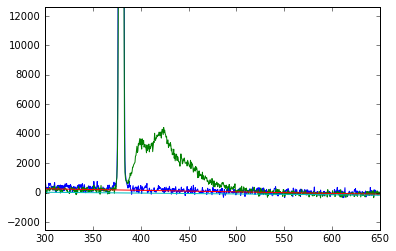

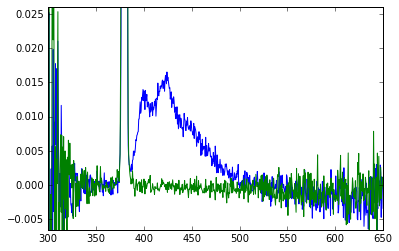

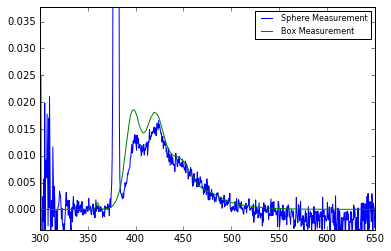

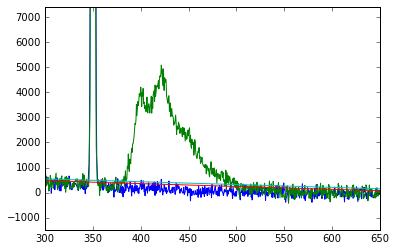

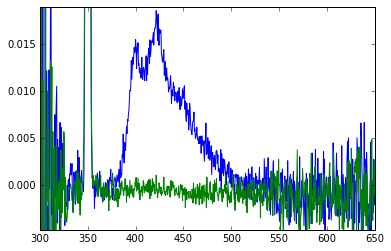

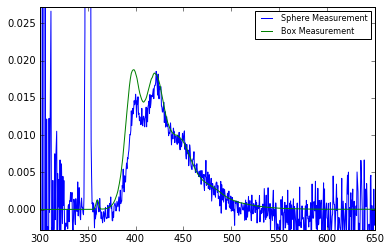

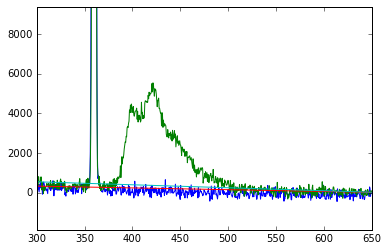

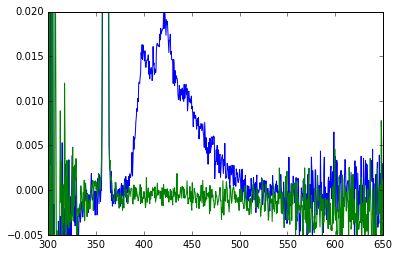

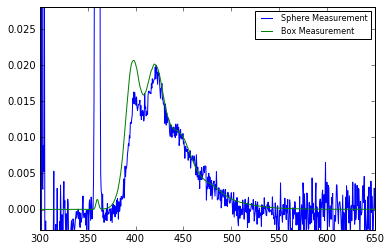

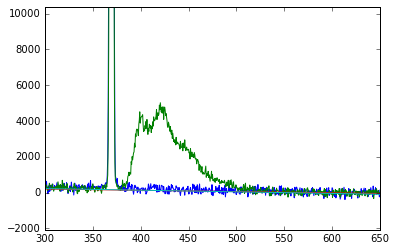

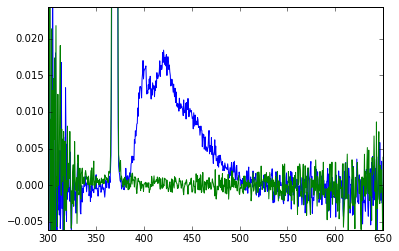

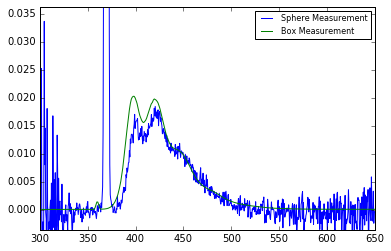

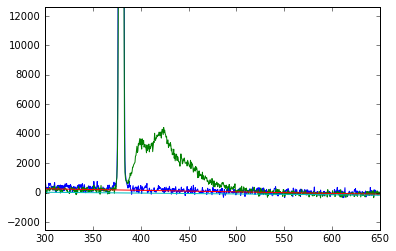

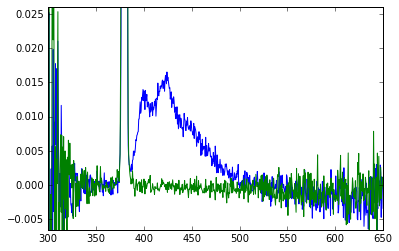

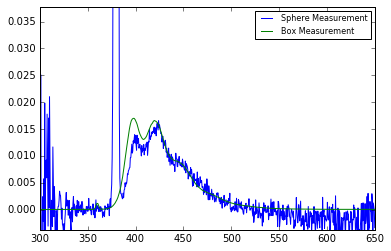

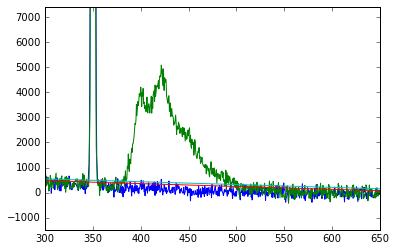

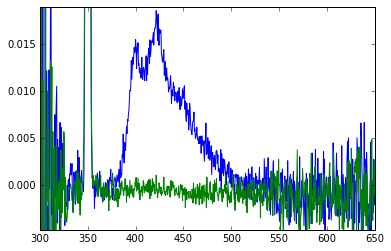

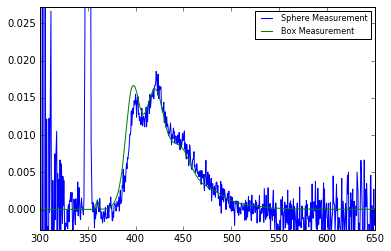

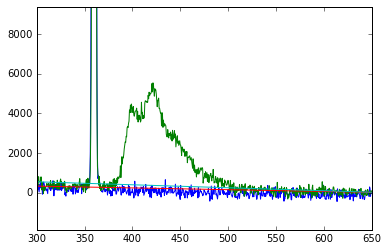

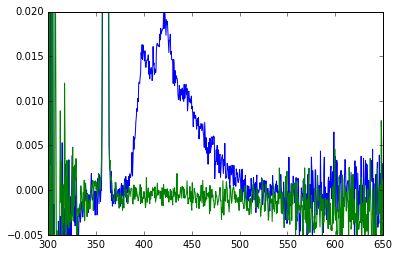

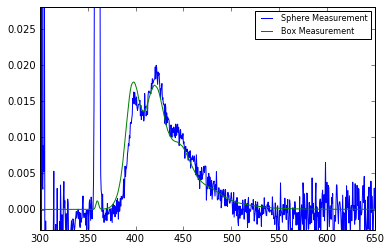

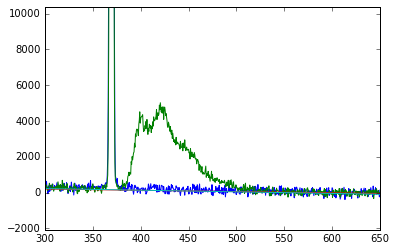

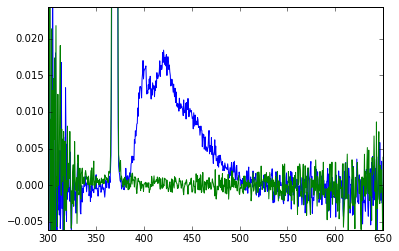

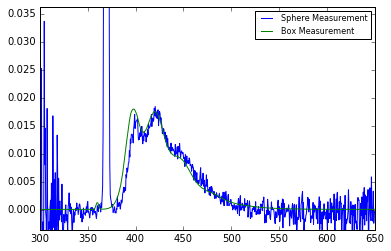

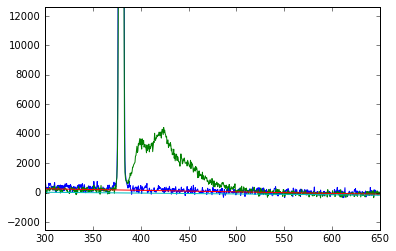

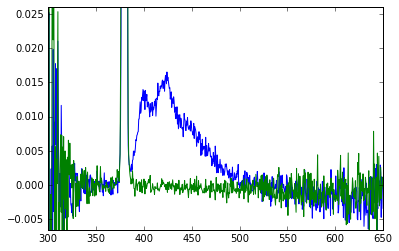

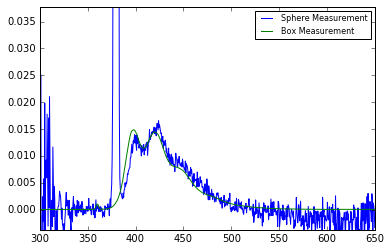

In [13]:
%matplotlib inline
solventpaths = ["C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\bisMSB_LAB\\EmissionScan_LAB_ex{0}_2sec_160823.txt".format(10*i + 350) for i in range(4)]
samplepaths = ["C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\bisMSB_LAB\\EmissionScan_bisMSBinLAB_4.47mgL_ex{0}_2sec_160824.txt".format(10*i+350) for i in range(4)]
FileWLCorr = False
makeplots = True
avglen = 10
BLoffsetrange = slice(-100, -1)

AbsWLmin = [345 + i*10 for i in range(4)]
AbsWLmax = [355 + i*10 for i in range(4)]
EmWLmin = [max(380, AbsWLmax[i]) for i in range(4)]
EmWLmax = 500

boxpath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Emission\\bisMSBlab\\"
FitWLmin = 460
fitminarray = [420 + i*10 for i in range(7)]
FitWLmax = 500
templatepath = boxpath + 'bisMSB_LAB_0.894mgL_ex360.txt'

syncscanpath = "C:\\Users\\Samsung\\Desktop\\QY_Project\\Henry's Data\\Henry\\Sphere\\EmissionCorrection\\SyncScan_ExcorrFile_NoEmcorr_160823.txt"


metaresults = [[CalcQY(solventpaths[i], samplepaths[i], templatepath, syncscanpath, AbsWLmin[i], AbsWLmax[i],
                              EmWLmin[i], EmWLmax, fitmin, FitWLmax, templateshift=1.5) for i in range(4)] for fitmin in fitminarray]

In [19]:
import matplotlib.pyplot as plt

solventobj = FluorSpec.PTI_Data.PTI_Data(solventpath)

if makeplots:
    fig = plt.figure()
    yvals = solventobj.FileSpecCorrected-np.mean(solventobj.FileSpecCorrected[BLoffsetrange])
    plt.plot(solventobj.WL, yvals)
    plt.ylim(-max(yvals)/100,max(yvals)/20)

sampleobj = FluorSpec.PTI_Data.PTI_Data(samplepath)

if makeplots:
    plt.plot(sampleobj.WL, sampleobj.FileSpecCorrected-np.mean(sampleobj.FileSpecCorrected[BLoffsetrange]))

BL, solvent_BLsub = subtractBL(solventobj.WL, 
                               list(solventobj.FileSpecCorrected - \
                                    np.mean(solventobj.FileSpecCorrected[BLoffsetrange])), avglen)

if makeplots:
    plt.plot(solventobj.WL, BL)

if FileWLCorr:
    WLcorr = np.interp(solventobj.WL, corrfile.WL, WLcorrfile)
else:
    WLcorr = np.interp(solventobj.WL, SyncScan.WL, WLcorrection)

solvent = (solventobj.FileSpecCorrected - np.mean(solventobj.FileSpecCorrected[BLoffsetrange]) - BL)*WLcorr
Usolvent = solventobj.UFileSpecCorrected*WLcorr
sample = (sampleobj.FileSpecCorrected-np.mean(sampleobj.FileSpecCorrected[BLoffsetrange]) - BL)*WLcorr
Usample = sampleobj.UFileSpecCorrected*WLcorr

if makeplots:
    plt.fig = figure()
    plt.plot(sampleobj.WL, sample)
    plt.plot(solventobj.WL, solvent)
    plt.ylim(-max(solvent)/100,max(solvent)/20)

xlow_abs = solventobj.WL.index(AbsWLmin)
xhigh_abs = solventobj.WL.index(AbsWLmax)
Npeak = sum(solventobj.FileSpecCorrected[xlow_abs:xhigh_abs])
print("# counts in peak = {0}".format(Npeak))
Nabs = sum(solvent[xlow_abs:xhigh_abs]) - sum(sample[xlow_abs:xhigh_abs])
#UNabs = np.sqrt(sum(solvent[xlow_abs:xhigh_abs])**2 + sum(sample[xlow_abs:xhigh_abs])**2)
Ncounts = sum(solventobj.FileSpecCorrected[xlow_abs:xhigh_abs]) - sum(sampleobj.FileSpecCorrected[xlow_abs:xhigh_abs])
print("# absorbed (uncorrected) = {0}".format(Ncounts))
#UNabs = Nabs*(np.sqrt(Ncounts)/Ncounts)**2
UNabs = np.sqrt(sum(Usolvent[xlow_abs:xhigh_abs]**2) + sum(Usample[xlow_abs:xhigh_abs]**2))

xlow_emit = solventobj.WL.index(EmWLmin)
xhigh_emit = solventobj.WL.index(EmWLmax)
Nemit = sum(sample[xlow_emit:xhigh_emit]) - sum(solvent[xlow_emit:xhigh_emit])
Nemit2 = sum(sample[xlow_emit:xhigh_emit])
Ncounts = sum(sampleobj.FileSpecCorrected[xlow_emit:xhigh_emit]) - sum(solventobj.FileSpecCorrected[xlow_emit:xhigh_emit])
#UNemit = Nemit*(np.sqrt(Ncounts)/Ncounts)**2
UNemit = np.sqrt(sum(Usample[xlow_emit:xhigh_emit]**2) + sum(Usolvent[xlow_emit:xhigh_emit]**2))

QY = Nemit/Nabs
QY2 = Nemit2/Nabs
UQY = QY*(np.sqrt((UNemit/Nemit)**2 + (UNabs/Nabs)**2))
print("Nemit = {0}".format(Nemit))
print("Nabs = {0}".format(Nabs))
print("QY = {0} +/- {1}".format(QY, UQY))
print("Linear extrap QY = {0}".format(QY2))

fig = figure()
plot(solventobj.WL, solventobj.FileSpecCorrected-np.mean(solventobj.FileSpecCorrected[BLoffsetrange]) - BL)
ylim(-500,300)

Initializing PTI_Data at Tue Oct  4 17:04:01 2016
Initializing PTI_Data at Tue Oct  4 17:04:01 2016


ValueError: [345, 355, 365, 375] is not in list

- Without subtracting baseline, no WL correction: QY = 

- Subtracting baseline, no WL correction: QY = 

- Subtracting baseline, WL correction: QY = 

- Subtracting baseline, default excorr: QY = 

- Subtracting baseline, emcorr-sphere-quanta: QY = 

- Choosing a different baseline region, or different integration limits, can have a big effect. The sensitivity to these effects should diminish with a greater bis-MSB concentration.

- I'm also noticing that the corrections are skewing the results because the baseline isn't *flat*. I can take a fit of the baseline to try and flatten it out, then subtract the fit from both before applying the correction.

    * Actually, the difference this makes is miniscule (at least for a 350 nm excitation).
    
- The other effect that may be skewing these results is the emission correction: when I acquire these data I implictly assume that the baseline is correctly subtracted, how valid is this assumption?

- Alternatively it could be an experimental effect: what if the vial happened to be cleaner during the LAB measurement?

- Finally, the difference between a relatively dirty (wiped with a kim wipe) cuvette -- EmissionScan_bisMSBinLAB_4.47mgL_ex350_2sec.txt -- and a clean cuvette -- EmissionScan_bisMSBinLAB_4.47mgL_ex350_2sec_160824.txt -- is *enormous*: about 17% for this measurement.

Relative height = 0.024659195718253136
[ 0.00161235]
[  3.13901312e-05]


ValueError: [380, 380, 380, 390] is not in list

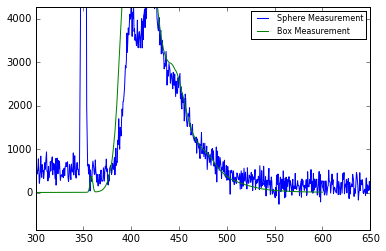

In [197]:
from scipy.integrate import trapz

ftr = fitter()

ftr.set_fit_range(FitWLmin, FitWLmax)
ftr.set_template_object(template)
relhgt = max(sampleobj.FileSpecCorrected)/max(template.FileSpecCorrected)
print("Relative height = {0}".format(relhgt))
pfit, perr = ftr.fit_function([relhgt], sampleobj, ftr.template_scale)
print(pfit)
print(perr)
ReabsSpec = np.array(template.FileSpecCorrected)*pfit[0]

if makeplots:
    fig = plt.figure()
    plt.plot(sampleobj.WL, np.array(sampleobj.FileSpecCorrected), label="Sphere Measurement")
    plt.plot(template.WL, ReabsSpec, label="Box Measurement")
    plt.legend(fontsize=8)
    plt.ylim(-max(sampleobj.FileSpecCorrected)/100,max(sampleobj.FileSpecCorrected)/20)

BL_reabs = np.interp(template.WL, sampleobj.WL, BL)
WLcorr_reabs = np.interp(template.WL, sampleobj.WL, WLcorr)

xlow_emit_reabs = template.WL.index(EmWLmin)
xhigh_emit_reabs = template.WL.index(EmWLmax)
dx_template = template.WL[1] - template.WL[0]
dx_solvent = solventobj.WL[1] - solventobj.WL[0]
Fsample_reabs = trapz(sample_reabs[xlow_emit_reabs:xhigh_emit_reabs], dx=dx_template)
Fsolvent_reabs = trapz(solvent[xlow_emit:xhigh_emit], dx=dx_solvent)
Nemit_reabs = Fsample_reabs - Fsolvent_reabs            

Asample_reabs = trapz(sample[xlow_abs:xhigh_abs], dx=dx_solvent)
Asolvent_reabs = trapz(solvent[xlow_abs:xhigh_abs], dx=dx_solvent)
Nabs_reabs = Asolvent_reabs - Asample_reabs

print("Nemit = {0}".format(Nemit_reabs))
print("Nabs = {0}".format(Nabs_reabs))

QY_reabs = Nemit_reabs/Nabs_reabs
UQY_reabs = QY_reabs*UQY/QY
print("QY = {0} +/- {1}".format(QY_reabs, UQY_reabs))


(345, 355)

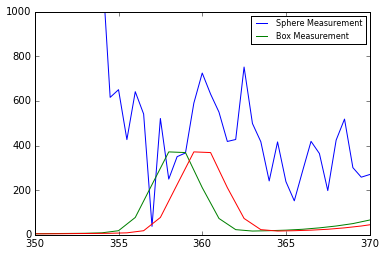

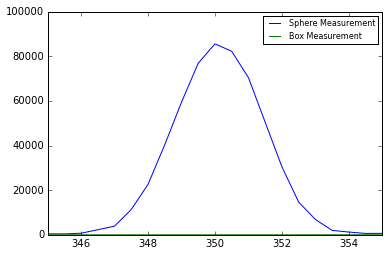

In [205]:
fig = plt.figure()
plt.plot(sampleobj.WL, np.array(sampleobj.FileSpecCorrected), label="Sphere Measurement")
plt.plot(template.WL, ReabsSpec, label="Box Measurement")
plt.legend(fontsize=8)
plt.ylim(0,1000)
plt.xlim(350,370)
plt.plot(np.array(template.WL)+1.5, ReabsSpec)

fig = plt.figure()
plt.plot(sampleobj.WL, np.array(sampleobj.FileSpecCorrected), label="Sphere Measurement")
plt.plot(template.WL, ReabsSpec, label="Box Measurement")
plt.legend(fontsize=8)
plt.ylim(0,100000)
plt.xlim(345,355)

